<h1>Audio</h1>

Wieso sind Töne und Geräusche wichtig?<br>
Auch diese können wie normale Daten wie Text oder Bilder mit einem neuralen Netz verarbeitet werden. Neurale Netze sind dafür sehr gut geeignet, diese können verschiedenste Features erfassen anders als die einfacheren Machine Learning Konzepte. Besonders wenn es komplexere Zusammenhänge gibt wie bei Bildern.

Es gibt unterschiedlichste Use-Cases wie:
- Spracherkennung (Wörter, Befehle, Audio-to-text)
- Klassifizierung von Tönen wie Musik.
- Umgebungswahrnehmung
- Geräusche differenzieren und Unterschiede erkennen

Um den Anfang zu machen, wollen wir als Ziel ein Model trainieren, dass Wörter erkennen soll.:
- Ein ASR Model (Automatic-speech-recognition)

Als Dataset nutzen wir:
> Speech Commands dataset (Warden, 2018) <br>
> https://www.tensorflow.org/datasets/catalog/speech_commands [Letzter Zugriff: 12.08.2024]

Dieses Dataset enthält folgende Wörter im Audioformat: "down", "go", "left", "no", "right", "stop", "up" und "yes"

In [1]:
# Imports 
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import IPython
from IPython import display

In [2]:
tf.__version__

'2.17.0'

Dan laden wir das Dataset herunter.

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
# Dataset enthält Ordner mit Audiodateien.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(f'Kommandos: {commands}')

Kommandos: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Jeder dieser Ordner enthält .wav Audiodateien, die wir abspielen können.
- Durch solch eine Ordnerstruktur kann direkt mit TensorFlow ein Dataset erstellt werden. Siehe TF Datasets.

<h2>Spiele Audiodatei ab</h2>

In [5]:
# Erstelle Liste mit Dateinamen.
files_names_down = os.listdir(os.path.join(DATASET_PATH, "down"))
len(files_names_down)

1000

In [8]:
files_names_down[0]

'004ae714_nohash_0.wav'

Audiodateien könne im Notebook über IPython oder HTML einfach abgespielt werden.

In [6]:
IPython.display.Audio("data/mini_speech_commands/down/004ae714_nohash_0.wav")

In [7]:
# Spiele verschiedene Dateien ab #
# Down # 
rdm = np.random.randint(1, len(files_names_down))
audo_file = DATASET_PATH+"/down/"
print("File: Down")
IPython.display.Audio(audo_file+files_names_down[rdm])

File: Down


In [8]:
# Spiele verschiedene Dateien ab #

categ = commands[np.random.randint(1, len(commands))]
index = np.random.randint(1, len(files_names_down))

categ_path     = DATASET_PATH+f"/{categ}"
list_categ_dir = os.listdir(categ_path)

audo_file = categ_path+f"/{list_categ_dir[index]}"

print(f"File: {audo_file}\nCommando: {categ}")
IPython.display.Audio(audo_file)

File: data/mini_speech_commands/yes/6094340e_nohash_0.wav
Commando: yes


<h2>Erstelle Dataset</h2>

Mit TensorFlow kann aus einem Verzeichnis direkt ein Dataset abgeleitet werden. Das vereinfach den Umgang mit den Daten.
- Siehe TF Datasets.

In [86]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [87]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_adapter',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_convert_variables_to_tensors',
 '_copy_trackable_to_cpu',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_export_to_saved_model_graph',
 '_flat_shapes',
 '_f

In [88]:
label_names = train_ds.class_names
train_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

In [89]:
# Entferne eine Achse, da Single-Channel # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [90]:
# Erstelle Test- und Validationset #
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds  = val_ds.shard(num_shards=2, index=1)

<h2>Eigene Aufnahmen</h2>

Um Dataset oder Daten für die Prediction zu erstellen, können wir verschiedene Methoden anwenden.

Für sounddevice: <br> 
> https://python-sounddevice.readthedocs.io/en/0.3.15/api/checking-hardware.html [Letzter Zugriff: 19.08.2024]

In [24]:
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

In [25]:
# Frequenz: 
freq = 44100
# Aufnahmezeit: 
record_time = 5

In [30]:
sd.query_devices(kind="input")

{'name': 'Mikrofon (USB Condenser Microph',
 'index': 1,
 'hostapi': 0,
 'max_input_channels': 1,
 'max_output_channels': 0,
 'default_low_input_latency': 0.09,
 'default_low_output_latency': 0.09,
 'default_high_input_latency': 0.18,
 'default_high_output_latency': 0.18,
 'default_samplerate': 44100.0}

In [52]:
# Aufnahme #
# - channels: 1 oder 2.
recording = \
    sd.rec(int(record_time * freq), samplerate=freq, channels=1)          
sd.wait()

In [53]:
recording

array([[0.00283813],
       [0.00335693],
       [0.00271606],
       ...,
       [0.00234985],
       [0.01815796],
       [0.0140686 ]], dtype=float32)

In [54]:
# Speichere # 
write("./data/data/recording0.wav", freq, recording)

In [58]:
# Mit wavio # 
wv.write("./data/data/recording0.wav", recording, freq, sampwidth=2)

Danach können wir die Audiodatei laden und beliebig nutzen.

In [57]:
# Playback: 
sd.play(recording, freq)
sd.wait()

In [39]:
# Kann auch heruntergeladen werden # 
IPython.display.Audio("./data/data/recording0.wav")

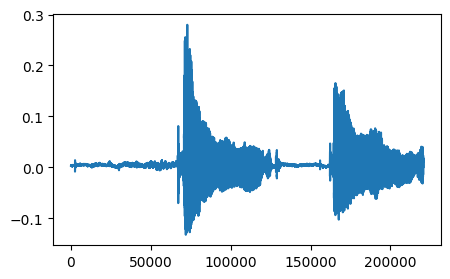

In [55]:
plt.figure(figsize=(5,3))
plt.plot(recording)

<h2>Visualisierung und weiteres zu Audioformaten</h2>

Wie oben zusehen ist, können Audiodateien visuell dargestellt werden.

In [91]:
example_audio_signals = []
example_audio_labels  = []
for example_audio, example_labels in train_ds.take(1):  
      print(example_audio.shape)
      print(example_labels.shape)
      example_audio_signals.append(example_audio)
      example_audio_labels.append(example_labels)

(32, 16000)
(32,)


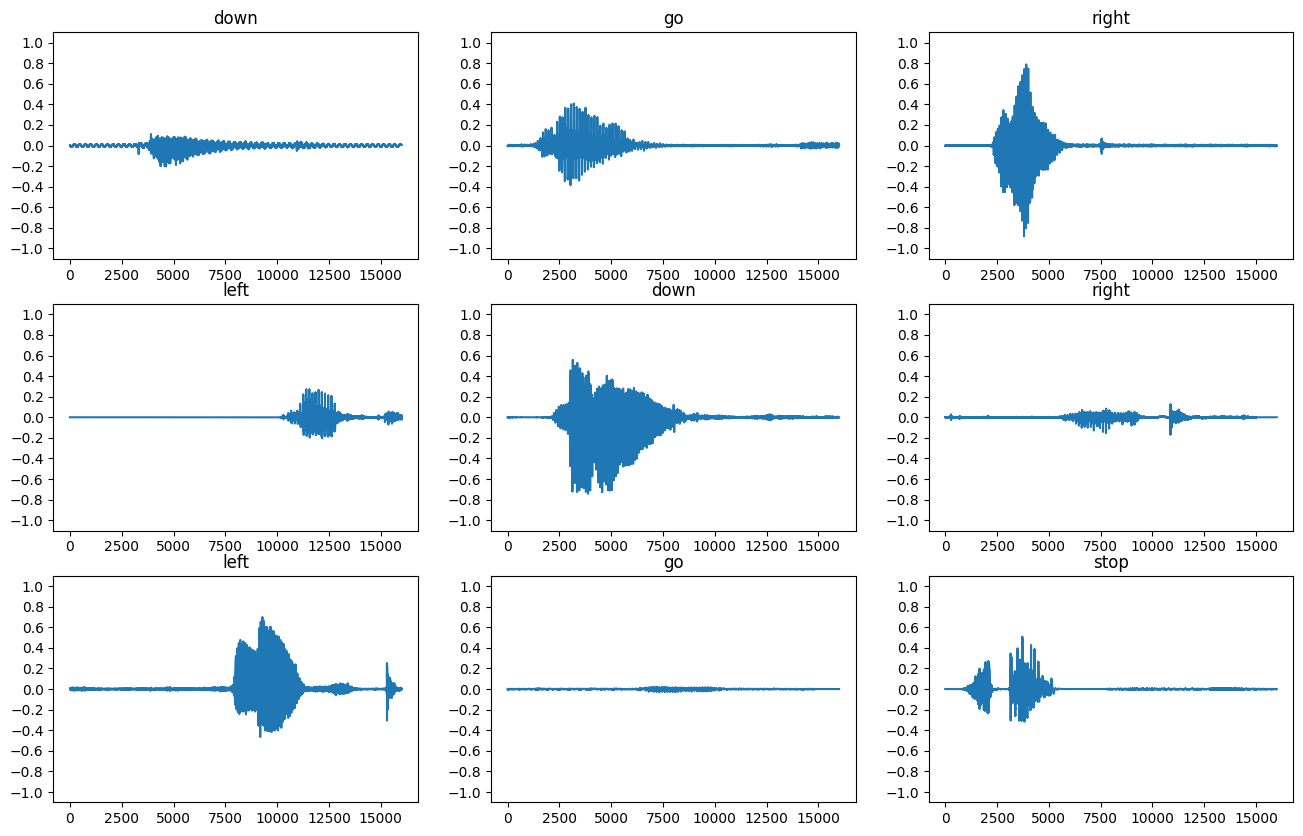

In [102]:
# Plote Dataset # 
plt.figure(figsize=(16, 10))

for i in range(9):
  plt.subplot(3, 3, i+1)
  audio_signal = example_audio_signals[0][i]
  plt.plot(audio_signal)
  plt.title(label_names[example_audio_labels[0][i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Für das spätere Training müssen die Daten von dem Waveform Format in ein anderes Format (STFT) überführt werden. <br>
STFT steht für short-time Fourier Transform, damit werden die .wav Dateien in eine Spektrogramm-Form gebracht, welche auch als 2D-Bild dargestellt werden kann. Dieses Format zeigt die Änderung der Frequenz über Zeit.

Für die Transformation bietet TensorFlow eigene Methoden.
- tf.signal.fft: Konvertiert das Audiosignal in Bestandteile, keine Zeitinformation
- tf.signal.stft: Teile Audiosignal in Fenster auf
  
Beide führen eine Fourier transformation aus. 

Wenn Audioclips sehr kurz sind, sollte ein Padding genutzt werden.